In [1]:
# -*- coding: utf-8 -*-
from skimage import io,transform
import glob
import os
import tensorflow as tf
import numpy as np
import time
import random
import matplotlib.pyplot as plt

#读取图片
def read_img(path):
    #os.listdir(path)表示在path路径下的所有文件和和文件夹列表
    #用cate记录五种花的文件路径
    cate=[path+x for x in os.listdir(path) if os.path.isdir(path+x)]
    imgs=[]  #存放所有的图片
    labels=[]  #图片的类别标签
    for idx,folder in enumerate(cate):
        for im in glob.glob(folder+'/*.jpg'):
            #print('reading the images:%s'%(im))#im表示某张图片的路径
            img=io.imread(im)
            img=transform.resize(img,(w,h))#图片resize为100*100
            imgs.append(img)
            labels.append(idx)
    #不用array的原因是copy时不会占用新的内存
    return np.asarray(imgs,np.float32),np.asarray(labels,np.int32)   

#部分图片可视化,每种花分别选取show_num 张
###1.每类花选择show_num张图片显示
###2.获取每类花的数量max_n
###3.对每类花，随机生成show_num个在0，max_n-1之间的数据，表示该类花随机选择的图片
###由于data中花是按顺序存放,i类花的第j个在data中的位置为i*max_n+j
def show(data,label):
    show_num = 5
    plt.figure()
    max_n = np.int(data.shape[0]/5)
    for i in range(show_num):
        a=[random.randint(0,max_n) for _ in range(show_num)]
        for j in range(show_num):
            plt.subplot(show_num,show_num,show_num*i+j+1)
            plt.imshow(data[a[j]+np.int(max_n*i)-1])
            plt.axis('off')
    plt.show()

#打乱顺序
###调用np.random.shuffle函数将有序数组变无序
###返回打乱顺序后的图片和对应的标签
def disturb(data,lable):
    num_example=data.shape[0]
    arr=np.arange(num_example)
    np.random.shuffle(arr)
    img=data[arr]
    labels=label[arr]
    return img,labels

#将所有数据分为训练集和验证集\测试集
def allocate(data,label):
    inter1 = 0.6
    inter2 = 0.8
    num_example = data.shape[0]
    s1 = np.int(num_example*inter1)
    s2 = np.int(num_example*inter2)
    x_train = data[:s1]
    y_train = label[:s1]
    x_val = data[s1:s2]
    y_val = label[s1:s2]
    x_test = data[s2:]
    y_test = label[s2:]
    return x_train,y_train,x_val,y_val,x_test,y_test

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [2]:
#-----------------构建网络----------------------
def Network():
#占位符
    #第一个卷积层（100——>50)
    conv1=tf.layers.conv2d(
          inputs=x,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu,
          kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    pool1=tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    #第二个卷积层(50->25)
    conv2=tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu,
          kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    pool2=tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    #第三个卷积层(25->12)
    conv3=tf.layers.conv2d(
          inputs=pool2,
          filters=128,
          kernel_size=[3, 3],
          padding="same",
          activation=tf.nn.relu,
          kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    pool3=tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    #第四个卷积层(12->6)
    conv4=tf.layers.conv2d(
          inputs=pool3,
          filters=128,
          kernel_size=[3, 3],
          padding="same",
          activation=tf.nn.relu,
          kernel_initializer=tf.truncated_normal_initializer(stddev=0.01))
    pool4=tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)

    re1 = tf.reshape(pool4, [-1, 6 * 6 * 128])

    #全连接层
    dense1 = tf.layers.dense(inputs=re1, 
                      units=1024, 
                      activation=tf.nn.relu,
                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                      kernel_regularizer=tf.contrib.layers.l2_regularizer(0.003))
    dense2= tf.layers.dense(inputs=dense1, 
                      units=512, 
                      activation=tf.nn.relu,
                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                      kernel_regularizer=tf.contrib.layers.l2_regularizer(0.003))
    logits= tf.layers.dense(inputs=dense2, 
                        units=5, 
                        activation=None,
                        kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(0.003))
    
    return logits
    

In [3]:
def calculate(logits,y_):
    #将logits乘以1保存为logits_eval，方便导入模型时调用
    b = tf.constant(value=1,dtype=tf.float32)
    logits_eval = tf.multiply(logits,b,name='logits_eval') 
    #计算分类器器算出的每个类的概率logits与标签y_的差异
    loss=tf.losses.sparse_softmax_cross_entropy(labels=y_,logits=logits)
    #一个寻找全局最优点的优化算法,可以避免陷入局部最优点
    train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    #计算正确率
    correct_prediction = tf.equal(tf.cast(tf.argmax(logits,1),tf.int32), y_)    
    acc= tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return loss,train_op,acc


#定义一个函数，按批次取数据
def minibatches(inputs=None, targets=None, batch_size=None, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]

In [4]:
#训练和测试数据，可将n_epoch设置更大一些
def train(x_train,y_train,x_val,y_val,train_op,loss,acc):
    n_epoch=10
    batch_size=64
    # 用于保存和载入模型
    saver = tf.train.Saver(max_to_keep=1)
    sess=tf.InteractiveSession()  
    sess.run(tf.global_variables_initializer())
    #保存训练过程中训练损失和训练集的正确率
    Train_loss= np.zeros(n_epoch)
    Train_acc = np.zeros(n_epoch)
    #保存训练过程中验证损失和验证集的正确率
    Val_loss= np.zeros(n_epoch)
    Val_acc = np.zeros(n_epoch)
    for epoch in range(n_epoch):
        start_time = time.time()
        #training
        train_loss, train_acc, n_batch = 0, 0, 0
        for x_train_a, y_train_a in minibatches(x_train, y_train, batch_size, shuffle=True):
            _,err,ac=sess.run([train_op,loss,acc], feed_dict={x: x_train_a, y_: y_train_a})
            train_loss += err; 
            train_acc += ac; 
            n_batch += 1
        print('epoch',epoch+1)
        Train_loss[epoch] = train_loss/ n_batch
        Train_acc[epoch] = train_acc/ n_batch
        print("   train loss: %f" % Train_loss[epoch])
        print("   train acc: %f" %  Train_acc[epoch])
        #validation
        val_loss, val_acc, n_batch = 0, 0, 0
        for x_val_a, y_val_a in minibatches(x_val, y_val, batch_size, shuffle=False):
            err, ac = sess.run([loss,acc], feed_dict={x: x_val_a, y_: y_val_a})
            val_loss += err; 
            val_acc += ac; 
            n_batch += 1
        Val_loss[epoch] = val_loss/ n_batch
        Val_acc[epoch] = val_acc/ n_batch
        print("   validation loss: %f" %  Val_loss[epoch])
        print("   validation acc: %f" %  Val_acc[epoch])
    N = [i+1 for i in range(n_epoch)]
    saver.save(sess,modle_path)
    sess.close()
    return Train_loss,Train_acc,Val_loss,Val_acc,N
    

In [ ]:
def test(x_test,y_test):
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph('E:/flowers/modle.ckpt.meta')
        saver.restore(sess,tf.train.latest_checkpoint('E:/flowers/'))
        #获取默认系统图
        graph = tf.get_default_graph()
        x = graph.get_tensor_by_name("x:0")
        feed_dict = {x:x_test}
        logits = graph.get_tensor_by_name("logits_eval:0")
        #得到预测结果
        classification_result = sess.run(logits,feed_dict)
        #根据索引通过字典对应花的分类
        output = []
        output = tf.argmax(classification_result,1).eval()
        print(output)
        Real = tf.equal(output,y_test).tolist.count(True)
        test_acc = Real / x_test.shape[0]
        return test_acc

D:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


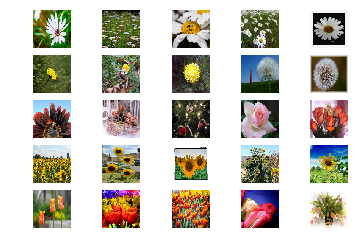

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
epoch 1
   train loss: 1.608465
   train acc: 0.239430
   validation loss: 1.607365
   validation acc: 0.228693
epoch 2
   train loss: 1.603009
   train acc: 0.249540
   validation loss: 1.608791
   validation acc: 0.228693
epoch 3
   train loss: 1.600993
   train acc: 0.249081
   validation loss: 1.611610
   validation acc: 0.228693
epoch 4
   train loss: 1.596854
   train acc: 0.258732
   validation loss: 1.587299
   validation acc: 0.247159
epoch 5
  

In [ ]:
path='e:/flowers/'
modle_path = 'e:/flowers/modle.ckpt'
#图片裁剪后大小为100*100
w=100
h=100
c=3
#读取图片
data ,label = read_img(path)
#部分显示
show(data,label)
#打乱图片
data,label = disturb(data,label)
#分成三个集，训练测试验证集
x_train,y_train,x_val,y_val,x_test,y_test = allocate(data,label)
#建立CNN网络
#占位符
x=tf.placeholder(tf.float32,shape=[None,w,h,c],name='x')
y_=tf.placeholder(tf.int32,shape=[None,],name='y_')
#根据CNN网络得到分类结果logits
logits = Network()
#根据模型结果和真实结果计算正确率、训练损失
loss,train_op,acc = calculate(logits,y_)
#训练模型
Train_loss,Train_acc,Val_loss,Val_acc,N = train(x_train,y_train,x_val,y_val,train_op,loss,acc)
acc = test(x_test,y_test)
print(acc)

In [ ]:
plt.figure()
plt.plot(N,Train_loss,'r',label = 'train loss')
plt.plot(N,Train_acc,'b',label='accuracy')
plt.plot(N,Val_loss,'g',label='validation loss')
plt.plot(N,Val_acc,'k',label='validation accuracy')
plt.legend()
plt.ioff()